In [1]:
import pandas as pd
import asyncio
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import contractions
from googletrans import Translator
import json
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary

from gensim.models import LdaModel
from gensim.models import CoherenceModel

import pyLDAvis.gensim_models as gensimvis
import pyLDAvis


import nest_asyncio
nest_asyncio.apply()

In [2]:
# load data
df = pd.read_csv('prepro_cleaned_reviews.csv')

In [3]:
df

,rating,reviews,company,province,parsed_date,processed_reviews
0,5,"Located at the Padang Old City area, just arou...",JNE,Aceh,2024-04-25,letak kawasan kota tua jembatan siti nurbaya s...
1,1,"Bad service given to customers, my own experie...",JNE,Aceh,2021-01-21,layan buruk langgan alam ambil jasa kirim kelu...
2,5,"Nice Place, they're working on rebuild their o...",JNE,Aceh,2022-01-21,bagus upaya bangun kantor orang orang hebat layan
3,5,Good delivery service for customers in this co...,JNE,Aceh,2023-01-21,kirim langgan negara
4,5,Good service,JNE,Aceh,2022-01-21,layan bagus
...,...,...,...,...,...,...
17659,1,Kargo Silambat,Sicepat,Sumatera Utara,2021-01-21,kargo lambat
17660,1,SILELET CEMBRETTTTTT,Sicepat,Sumatera Utara,2021-01-21,lambat cembret
17661,1,Lambat sekali....,Sicepat,Sumatera Utara,2021-01-21,lambat
17662,1,KERAS!!!!!,Sicepat,Sumatera Utara,2021-01-21,keras


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17664 entries, 0 to 17663
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   rating             17664 non-null  int64 
 1   reviews            17664 non-null  object
 2   company            17664 non-null  object
 3   province           17664 non-null  object
 4   parsed_date        17664 non-null  object
 5   processed_reviews  17080 non-null  object
dtypes: int64(1), object(5)
memory usage: 828.1+ KB


In [5]:
modeling_df = df.copy()

In [6]:
jelek_modeling = modeling_df.query("rating <= 3" )
bagus_modeling = modeling_df.query("rating >= 4")

In [7]:
jelek_modeling.shape

(13927, 6)

In [8]:
bagus_modeling.shape

(3737, 6)

# 1. jelek modeling

In [9]:
# Ensure the 'processed_reviews' column is treated as string
jelek_modeling['processed_reviews'] = jelek_modeling['processed_reviews'].astype(str)

# Tokenize the processed_reviews column
jelek_modeling['tokenized_reviews'] = jelek_modeling['processed_reviews'].apply(word_tokenize)

C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_22060\2846537713.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jelek_modeling['processed_reviews'] = jelek_modeling['processed_reviews'].astype(str)
C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_22060\2846537713.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jelek_modeling['tokenized_reviews'] = jelek_modeling['processed_reviews'].apply(word_tokenize)


In [10]:
# # Save the result to a new CSV file
# output_file = 'tokenized_reviews.csv'
# modeling_df.to_csv(output_file, index=False)

# print(f"Tokenized reviews saved to {output_file}")

In [11]:
jelek_modeling

,rating,reviews,company,province,parsed_date,processed_reviews,tokenized_reviews
1,1,"Bad service given to customers, my own experie...",JNE,Aceh,2021-01-21,layan buruk langgan alam ambil jasa kirim kelu...,"[layan, buruk, langgan, alam, ambil, jasa, kir..."
7,1,Too slow,JNE,Aceh,2016-01-23,lambat,[lambat]
18,2,Slow service,JNE,Aceh,2022-01-21,lambat,[lambat]
20,1,Bad service,JNE,Aceh,2019-01-22,buruk,[buruk]
24,1,The courier was too slow for many reasons even...,JNE,Aceh,2025-01-06,kurir lambat kira pakai sayang m,"[kurir, lambat, kira, pakai, sayang, m]"
...,...,...,...,...,...,...,...
17658,1,Lambat,Sicepat,Sumatera Utara,2021-01-21,lambat,[lambat]
17659,1,Kargo Silambat,Sicepat,Sumatera Utara,2021-01-21,kargo lambat,"[kargo, lambat]"
17660,1,SILELET CEMBRETTTTTT,Sicepat,Sumatera Utara,2021-01-21,lambat cembret,"[lambat, cembret]"
17661,1,Lambat sekali....,Sicepat,Sumatera Utara,2021-01-21,lambat,[lambat]


In [12]:
tokenized_reviews = jelek_modeling['tokenized_reviews'].tolist()  # Convert the column to a list of lists
dictionary = Dictionary(tokenized_reviews)

In [13]:
# # Save dictionary for future use
# dictionary.save('lda_dictionary.dict')

# Print dictionary information
print(f"Dictionary created with {len(dictionary)} unique tokens.")

Dictionary created with 10834 unique tokens.


In [14]:
# Word counts
word_counts = dictionary.cfs  # cfs = term frequency across the corpus
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

In [15]:
# Cumulative frequency
word_frequencies = [count for _, count in sorted_word_counts]
cumulative_frequencies = [sum(word_frequencies[:i]) for i in range(1, len(word_frequencies) + 1)]

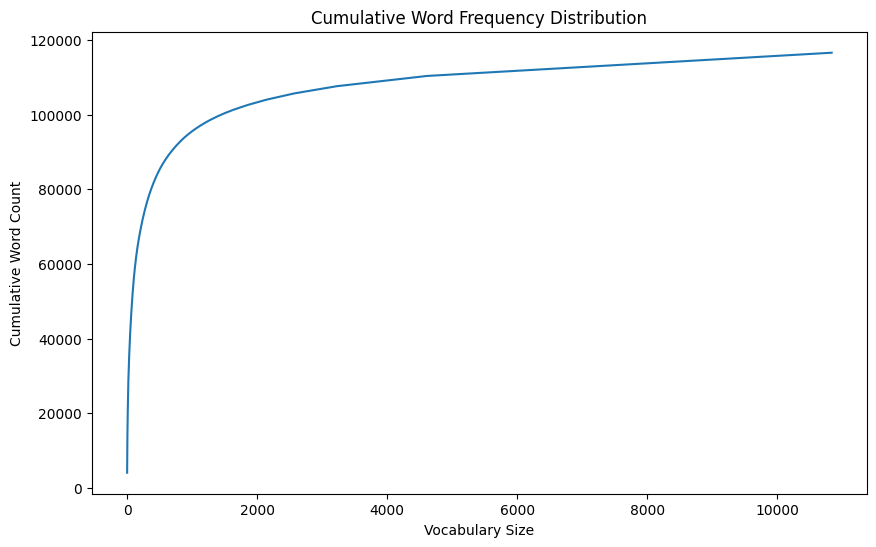

In [16]:
# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_frequencies) + 1), cumulative_frequencies)
plt.xlabel('Vocabulary Size')
plt.ylabel('Cumulative Word Count')
plt.title('Cumulative Word Frequency Distribution')
plt.show()

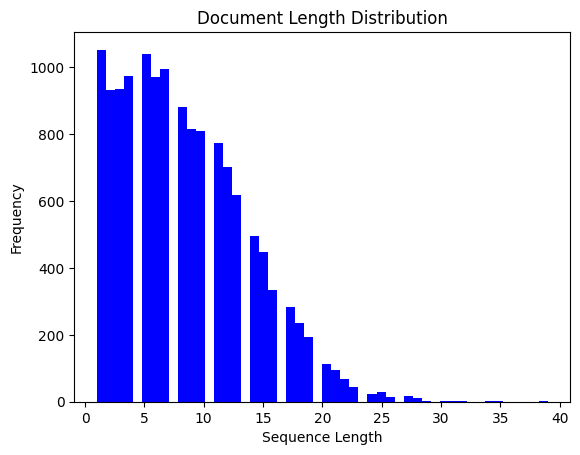

count    13927.000000
mean         8.373160
std          5.362486
min          1.000000
25%          4.000000
50%          8.000000
75%         12.000000
90%         16.000000
95%         18.000000
max         39.000000
Name: tokenized_reviews, dtype: float64


In [17]:
sequence_lengths = jelek_modeling['tokenized_reviews'].apply(len)

# Plot sequence length distribution
plt.hist(sequence_lengths, bins=50, color='blue')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Document Length Distribution')
plt.show()

# Print descriptive stats
print(sequence_lengths.describe(percentiles=[0.25, 0.5, 0.75, 0.90, 0.95]))

Average banyaknya token untuk text per review = ~8 tokens. 3 sampe 18 tokens an lah. Artinya review kebanyakan singkat padat sumpah serapah, hahaha. Kali bisa jadi EDA juga.

In [18]:
top_n = 2000  # Adjust berdasarkan "Cumulative Word Frequency Distribution"
word_coverage = sum([freq for _, freq in sorted_word_counts[:top_n]]) / sum(word_frequencies)
print(f"Word Coverage with top {top_n} words: {word_coverage:.2%}")

Word Coverage with top 2000 words: 88.62%


Nge limit pake 6000 kata udah bisa cover 95% vocabs. Artinya pakai 6000 kata pun udah nge-cover semua.

In [19]:
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=2000)
print(f"Filtered dictionary size: {len(dictionary)}")

Filtered dictionary size: 2000


param no_below=5:
- nge remove kata-kata yang hanya muncul di bawah 5 review.

param no_above=0.5:
- remove kata-kata yang muncul di lebih dari 50% dari review review an. Kemungkinan akan ng-remove kata "kirim"

keep_n=6000:
- Lihat di atas

In [20]:
# bikin bag of words
corpus = [dictionary.doc2bow(review) for review in tokenized_reviews]

---
Coba modeling

In [21]:
lda_model = LdaModel(corpus=corpus, 
                     id2word=dictionary,
                     alpha='auto',
                     eta='auto',
                     iterations=100, 
                     num_topics=3, 
                     chunksize=500, 
                     passes=80, 
                     random_state=37)

corpus: corpusnya.

id2word: dictionary di atas.

num_topics: jumlah cluster.

chunksize: Di proses berapa banyak dalam sekali proses. 500 review-an sekali proses.

passes: Berapa kali algorithm nya passes through iterasi nya. More passes katanya improve accuracy cuman lebih lama aja.

random_state: seed.

In [22]:
for i, topic in lda_model.show_topics(num_topics=4, num_words=30, formatted=False):
    print(f"Topic {i + 1}:")
    print(" ".join([word for word, _ in topic]))
    print()

Topic 1:
lambat kirim layan pakai cepat ekspedisi buruk jasa kecewa sortir ganti baik estimasi hari tahan nama minggu bayar sesuai kota waktu lebih bagus hilang beli rugi langgan jual ubah mahal

Topic 2:
paket nomor terima customer service telepon barang jalan cek resi gerak pas telpon whatsapp mana butuh respon stuck hubung kembali bintang pusat kemarin pagi cod gudang status gin angkat sortation

Topic 3:
antar kerja kantor tutup rumah orang kurir pesan tuju alas niat bilang langsung konfirmasi suruh salah malas ambil bawa tunggu mohon lokasi update masuk cabang terang nan cari besok tulis



In [23]:
coherence_model = CoherenceModel(model=lda_model, texts=jelek_modeling['tokenized_reviews'], dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

In [24]:
print(f"Coherence Score: {coherence_score}")

Coherence Score: 0.4238004738540748


In [25]:
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

---

In [26]:
# Get topic distributions for the first 5 documents
for doc_id in range(5):
    print(f"Document {doc_id}: {lda_model.get_document_topics(corpus[doc_id])}")
    print(f"Original Text: {tokenized_reviews[doc_id]}")
    print()

Document 0: [(0, 0.6484998), (1, 0.14221223), (2, 0.209288)]
Original Text: ['layan', 'buruk', 'langgan', 'alam', 'ambil', 'jasa', 'kirim', 'keluar', 'biaya', 'kali', 'isi', 'makan', 'tugas']

Document 1: [(0, 0.50352186), (1, 0.22650927), (2, 0.26996896)]
Original Text: ['lambat']

Document 2: [(0, 0.50352186), (1, 0.22650927), (2, 0.26996896)]
Original Text: ['lambat']

Document 3: [(0, 0.50351644), (1, 0.22651176), (2, 0.26997188)]
Original Text: ['buruk']

Document 4: [(0, 0.4651843), (1, 0.290544), (2, 0.24427176)]
Original Text: ['kurir', 'lambat', 'kira', 'pakai', 'sayang', 'm']



In [27]:
# assign label per topic
topic_labels = {
    0: "Delay/ Lambat Pengiriman",
    1: "Kualitas Pelayan Buruk",
    2: "Komunikasi Kurir"
}

In [28]:
# Assign labels to documents
doc_topics = [max(lda_model.get_document_topics(doc), key=lambda x: x[1])[0] for doc in corpus]
jelek_modeling['topic'] = [topic_labels[topic] for topic in doc_topics]

C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_22060\3944936635.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jelek_modeling['topic'] = [topic_labels[topic] for topic in doc_topics]


In [29]:
# Save labeled documents
modeling_df.to_csv("labeled_documents.csv", index=False)

In [30]:
jelek_modeling

,rating,reviews,company,province,parsed_date,processed_reviews,tokenized_reviews,topic
1,1,"Bad service given to customers, my own experie...",JNE,Aceh,2021-01-21,layan buruk langgan alam ambil jasa kirim kelu...,"[layan, buruk, langgan, alam, ambil, jasa, kir...",Delay/ Lambat Pengiriman
7,1,Too slow,JNE,Aceh,2016-01-23,lambat,[lambat],Delay/ Lambat Pengiriman
18,2,Slow service,JNE,Aceh,2022-01-21,lambat,[lambat],Delay/ Lambat Pengiriman
20,1,Bad service,JNE,Aceh,2019-01-22,buruk,[buruk],Delay/ Lambat Pengiriman
24,1,The courier was too slow for many reasons even...,JNE,Aceh,2025-01-06,kurir lambat kira pakai sayang m,"[kurir, lambat, kira, pakai, sayang, m]",Delay/ Lambat Pengiriman
...,...,...,...,...,...,...,...,...
17658,1,Lambat,Sicepat,Sumatera Utara,2021-01-21,lambat,[lambat],Delay/ Lambat Pengiriman
17659,1,Kargo Silambat,Sicepat,Sumatera Utara,2021-01-21,kargo lambat,"[kargo, lambat]",Delay/ Lambat Pengiriman
17660,1,SILELET CEMBRETTTTTT,Sicepat,Sumatera Utara,2021-01-21,lambat cembret,"[lambat, cembret]",Delay/ Lambat Pengiriman
17661,1,Lambat sekali....,Sicepat,Sumatera Utara,2021-01-21,lambat,[lambat],Delay/ Lambat Pengiriman


In [31]:
jelek_modeling['topic'].value_counts()

topic
Delay/ Lambat Pengiriman    8463
Komunikasi Kurir            3777
Kualitas Pelayan Buruk      1687
Name: count, dtype: int64

In [32]:
bagus_modeling

,rating,reviews,company,province,parsed_date,processed_reviews
0,5,"Located at the Padang Old City area, just arou...",JNE,Aceh,2024-04-25,letak kawasan kota tua jembatan siti nurbaya s...
2,5,"Nice Place, they're working on rebuild their o...",JNE,Aceh,2022-01-21,bagus upaya bangun kantor orang orang hebat layan
3,5,Good delivery service for customers in this co...,JNE,Aceh,2023-01-21,kirim langgan negara
4,5,Good service,JNE,Aceh,2022-01-21,layan bagus
5,5,Very nice building and nice staff,JNE,Aceh,2023-01-21,bangun bagus staf
...,...,...,...,...,...,...
17647,5,Komplek pergudangan 👍👍 …,Sicepat,Sumatera Utara,2021-01-21,komplek gudang
17650,5,Semangat,Sicepat,Sumatera Utara,2021-01-21,semangat
17655,5,Kerja bagus,Sicepat,Sumatera Utara,2021-01-21,kerja bagus
17656,5,Bagus,Sicepat,Sumatera Utara,2021-01-21,bagus
